In [1]:
from pathlib import Path

PATH = Path('../data/raw/bs_ergb/2_VALIDATION')
sequence_dirs = sorted(list(PATH.glob('*')))

In [2]:
import numpy as np

In [56]:
from typing import Tuple
import pandas as pd

from dynamic_fusion.utils.datatypes import EventSchema
from pandera.typing import DataFrame

def bs_ergb_to_events(input: np.lib.npyio.NpzFile, image_shape: Tuple[int, int, int]) -> DataFrame[EventSchema]:
    x = input['x'] // 32
    y = input['y'] // 32
    H, W, _ = image_shape
    mask = (0 <= x) & (x < W) & (0 <= y) & (y < H)
    
    x = x[mask]
    y = y[mask]
    p = input['polarity'][mask]
    t = input['timestamp']
    t = (t - t[0]) / (t[-1] - t[0])
    t = t[mask]

    df = pd.DataFrame({
        'x': x.astype(np.int64),
        'y': y.astype(np.int64),
        'polarity' : x.astype(np.bool_),
        'timestamp': t.astype(np.float64)
    })

    return df

In [76]:
import cv2
from dynamic_fusion.data_generator.configuration import EventDiscretizerConfiguration
from dynamic_fusion.data_generator.event_discretizer import EventDiscretizer

eppf_frames = []
eppf_sequences = []

sequence_dir = sequence_dirs[0]

voxel_grid_dir = sequence_dir / 'events'
images_dir = sequence_dir / 'images'

voxel_grid_paths = sorted(list(voxel_grid_dir.glob('*.npz')))
event_datas = [np.load(path) for path in voxel_grid_paths]

image_paths = sorted(list(images_dir.glob('*.png')))
image = cv2.imread(str(image_paths[0]))[...,::-1]

eppfs_this_sequence = []

for event_data in event_datas:
    events = bs_ergb_to_events(event_data, image.shape)
    eppfs_this_sequence.append(len(events) / (image.shape[0]*image.shape[1]))

eppf_frames.extend(eppfs_this_sequence)
eppf_sequences.append(sum(eppfs_this_sequence) / len(eppfs_this_sequence))

(array([21.,  3.,  2.,  1.,  1.,  2.,  2.,  1.,  2.,  3.]),
 array([2.91958763e-04, 5.50287835e-02, 1.09765608e-01, 1.64502433e-01,
        2.19239258e-01, 2.73976082e-01, 3.28712907e-01, 3.83449732e-01,
        4.38186557e-01, 4.92923381e-01, 5.47660206e-01]),
 <BarContainer object of 10 artists>)

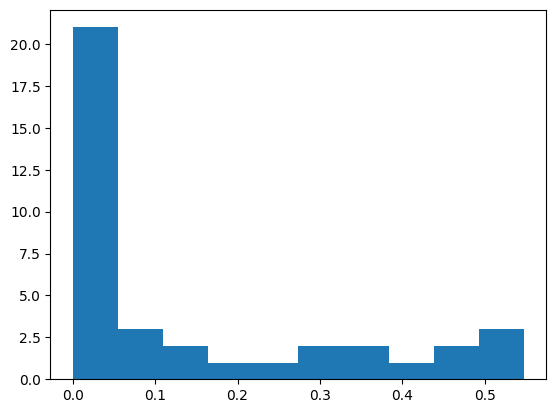

In [77]:
from matplotlib import pyplot as plt

plt.hist(eppf_frames, bins = 10)

In [133]:
import cv2
from dynamic_fusion.data_generator.configuration import EventDiscretizerConfiguration
from dynamic_fusion.data_generator.event_discretizer import EventDiscretizer
from tqdm import tqdm

from dynamic_fusion.utils.network import to_numpy
from dynamic_fusion.utils.visualization import create_red_blue_cmap, img_to_colormap

THRESHOLD = 1.3

config = EventDiscretizerConfiguration(number_of_temporal_bins=1, number_of_temporal_sub_bins_per_bin=2)
discretizer = EventDiscretizer(config, max_timestamp=1.)



sequence_dir = sequence_dirs[0]

voxel_grid_dir = sequence_dir / 'events'
images_dir = sequence_dir / 'images'

voxel_grid_paths = sorted(list(voxel_grid_dir.glob('*.npz')))
event_datas = [np.load(path) for path in voxel_grid_paths]

image_paths = sorted(list(images_dir.glob('*.png')))
images = [cv2.imread(str(image_path))[...,::-1] for image_path in image_paths]

OVERLAY = True

output_video_path = 'bsrgb/video.mp4'

width = images[0].shape[0]
fps = 5
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'

out = cv2.VideoWriter(output_video_path, fourcc, fps, (width * 3, images[0].shape[1]))
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)  # White color
line_type = 2
position = (10, 50)  # Position of the text (bottom left corner)


for i, event_data in enumerate(tqdm(event_datas)):
    events = bs_ergb_to_events(event_data, image.shape)
    discretized_events = discretizer.run({THRESHOLD: events}, image.shape[0:2])[THRESHOLD]
    image_start,image_end = images[i], images[i+1]

    colored_event_polarity_sum = (img_to_colormap(to_numpy(discretized_events.event_polarity_sum.sum(axis=1).squeeze()), create_red_blue_cmap(501))*255).astype(np.uint8)

    if OVERLAY:
        masked_colored_eps = colored_event_polarity_sum.copy()
        masked_colored_eps[masked_colored_eps == 127] = 0
        image_end = np.ascontiguousarray(image_end//2 + masked_colored_eps // 2)

    evr = discretized_events.event_count.sum(dim = (0,1)).mean()
    
    frame = np.concatenate([image_start, colored_event_polarity_sum, image_end], axis = 0).astype(np.uint8)
    frame = frame.transpose((1,0,2))[::-1]
    frame = np.ascontiguousarray(frame)

    cv2.putText(frame, f"Events per frame per pixel={evr:.2f}", position, font, font_scale, font_color, line_type)

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    out.write(frame)

out.release()

100%|██████████| 38/38 [00:03<00:00, 11.25it/s]


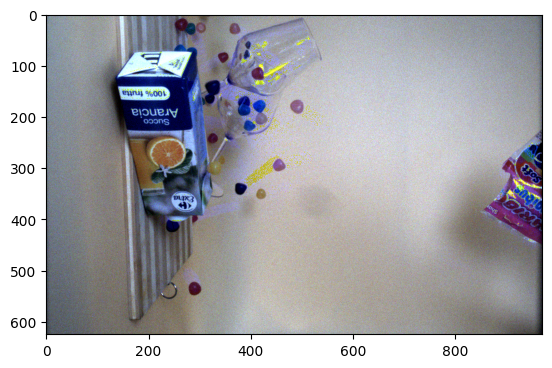

In [129]:
plt.imshow(image_end)

In [152]:
import einops
import torch
from dynamic_fusion.utils.superresolution import get_upscaling_pixel_indices_and_distances


nearest_pixels, corner_to_point_vectors = get_upscaling_pixel_indices_and_distances((10, 10), (10, 10))

n, x, y, _ = corner_to_point_vectors.shape

corner_to_point_vectors_expanded = einops.rearrange(corner_to_point_vectors, "N X Y Dims -> 1 N X Y Dims")
corner_to_point_vectors_normalized = corner_to_point_vectors_expanded * einops.repeat(torch.tensor((10, 10)) - 1, "Dims -> 1 N X Y Dims", N=n, X=x, Y=y)
corner_to_point_vectors_normalized = corner_to_point_vectors_normalized

corner_to_point_vectors[1,0,1]

tensor([-0.1111,  0.0000], dtype=torch.float64)

In [159]:
corner_to_point_vectors_normalized[0,3,1,0]

tensor([-1., -1.], dtype=torch.float64)

In [150]:
corner_to_point_vectors.shape

torch.Size([4, 10, 10, 2])

In [142]:
from dynamic_fusion.utils.superresolution import generate_coords_2d


start_coords = generate_coords_2d((10, 10))
end_coords = generate_coords_2d((10, 10))

corner_pixels = np.zeros((4, 10, 10, 2), dtype=np.int64)
two_zeros = np.zeros(2, dtype=np.float64)
start_resolution = np.array([10,10]).astype(np.float64)

first_corners = np.floor(end_coords * (start_resolution - 1))
first_corners = np.clip(first_corners, two_zeros, start_resolution - 2)
corner_pixels[0] = first_corners
corner_pixels[1] = first_corners + np.array([1, 0])
corner_pixels[2] = first_corners + np.array([0, 1])
corner_pixels[3] = first_corners + np.array([1, 1])

corner_pixels

array([[[[0, 0],
         [0, 1],
         [0, 2],
         [0, 3],
         [0, 4],
         [0, 5],
         [0, 6],
         [0, 6],
         [0, 8],
         [0, 8]],

        [[1, 0],
         [1, 1],
         [1, 2],
         [1, 3],
         [1, 4],
         [1, 5],
         [1, 6],
         [1, 6],
         [1, 8],
         [1, 8]],

        [[2, 0],
         [2, 1],
         [2, 2],
         [2, 3],
         [2, 4],
         [2, 5],
         [2, 6],
         [2, 6],
         [2, 8],
         [2, 8]],

        [[3, 0],
         [3, 1],
         [3, 2],
         [3, 3],
         [3, 4],
         [3, 5],
         [3, 6],
         [3, 6],
         [3, 8],
         [3, 8]],

        [[4, 0],
         [4, 1],
         [4, 2],
         [4, 3],
         [4, 4],
         [4, 5],
         [4, 6],
         [4, 6],
         [4, 8],
         [4, 8]],

        [[5, 0],
         [5, 1],
         [5, 2],
         [5, 3],
         [5, 4],
         [5, 5],
         [5, 6],
         [5, 6],
    

In [ ]:
from dynamic_fusion.utils.superresolution import find_corner_pixels, generate_coords_2d


def get_upscaling_pixel_indices_and_distances(
    start_resolution: Tuple[int, int], end_resolution: Tuple[int, int]
) -> Tuple[Int[torch.Tensor, "4 XUpscaled YUpscaled 2"], Float[torch.Tensor, "4 XUpscaled YUpscaled 2"]]:
    start_coords = generate_coords_2d(start_resolution)
    end_coords = generate_coords_2d(end_resolution)

    corner_pixels = find_corner_pixels(np.array(start_resolution), end_resolution, end_coords)

    corner_start_coords = start_coords[corner_pixels[..., 0], corner_pixels[..., 1]]
    corner_to_point_vectors = end_coords[None, :] - corner_start_coords

    return torch.tensor(corner_pixels), torch.tensor(corner_to_point_vectors)


In [138]:
nearest_pixels[0]

tensor([[[0, 0],
         [0, 1],
         [0, 2],
         [0, 3],
         [0, 4],
         [0, 5],
         [0, 6],
         [0, 6],
         [0, 8],
         [0, 8]],

        [[1, 0],
         [1, 1],
         [1, 2],
         [1, 3],
         [1, 4],
         [1, 5],
         [1, 6],
         [1, 6],
         [1, 8],
         [1, 8]],

        [[2, 0],
         [2, 1],
         [2, 2],
         [2, 3],
         [2, 4],
         [2, 5],
         [2, 6],
         [2, 6],
         [2, 8],
         [2, 8]],

        [[3, 0],
         [3, 1],
         [3, 2],
         [3, 3],
         [3, 4],
         [3, 5],
         [3, 6],
         [3, 6],
         [3, 8],
         [3, 8]],

        [[4, 0],
         [4, 1],
         [4, 2],
         [4, 3],
         [4, 4],
         [4, 5],
         [4, 6],
         [4, 6],
         [4, 8],
         [4, 8]],

        [[5, 0],
         [5, 1],
         [5, 2],
         [5, 3],
         [5, 4],
         [5, 5],
         [5, 6],
         [5, 6],
    

In [135]:
corner_to_point_vectors

tensor([[[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.1111],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.1111]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.1111],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.1111]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.1111],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.1111]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000],
    

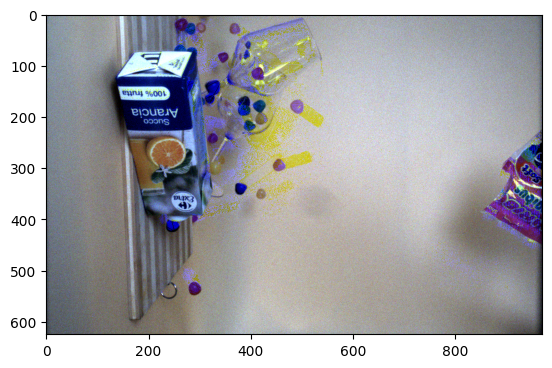

In [131]:
plt.imshow(image_end + test)

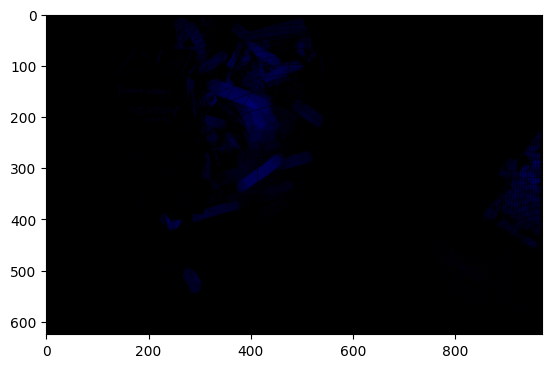

In [124]:
test = colored_event_polarity_sum.copy()
test[test == 127] = 0
plt.imshow(test // 2)